In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import GPy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils

## Model creation

In [2]:
# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
real_parameters = [0.1, 0.5, 3]

times = np.linspace(0, 20, 200)
org_values = model.simulate(real_parameters, times)

# take 5-10% of range as your std for noise
Vs, Rs = org_values.reshape(2, 200)
V_std = (Vs.max() - Vs.min()) * .1
R_std = (Rs.max() - Rs.min()) * .1

# Add noise
noise = [V_std, R_std]
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

In [3]:
bounds = pints.Boundaries(lower = [0, 0, 2], upper = [1, 1, 4])
log_prior = pints.UniformLogPrior(bounds)

In [4]:
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(real_log_likelihood, 1, input_parameters)
likelihoods[:5]

array([ -971.16843266, -2390.25786221,  -274.18942907, -1981.10778417,
        -524.94472478])

In [5]:
input_parameters[:5]

array([[0.13873558, 0.18152784, 3.64030599],
       [0.39612589, 0.99579544, 2.44985335],
       [0.27642927, 0.04095882, 2.9788973 ],
       [0.56133875, 0.27422986, 2.87068005],
       [0.34197639, 0.5481173 , 2.63854454]])

In [6]:
emu = emupints.GPEmulator(real_log_likelihood, input_parameters, likelihoods, normalize_input = True)

# Plotting surfaces for fixed parameters

In [7]:
# number of splits for each parameter in the surface
n_splits = 50

# each entry is a list of parameters that should be fixed
fixed_parameters = [
    [(0, 0.1)], # a = 0.1, 0.5, 1
    [(0, 0.5)], 
    [(0, 1)],
    [(1, 0.1)], # b = 0.1, 0.5, 1
    [(1, 0.5)], 
    [(1, 1)],
    [(2, 2)], # c = 2, 3, 4
    [(2, 3)], 
    [(2, 4)]
]

grid_shape = (3, 3)

# number of splits for each parameter in the surface
index_to_param_name = {
    0 : "a",
    1 : "b",
    2 : "c"
}

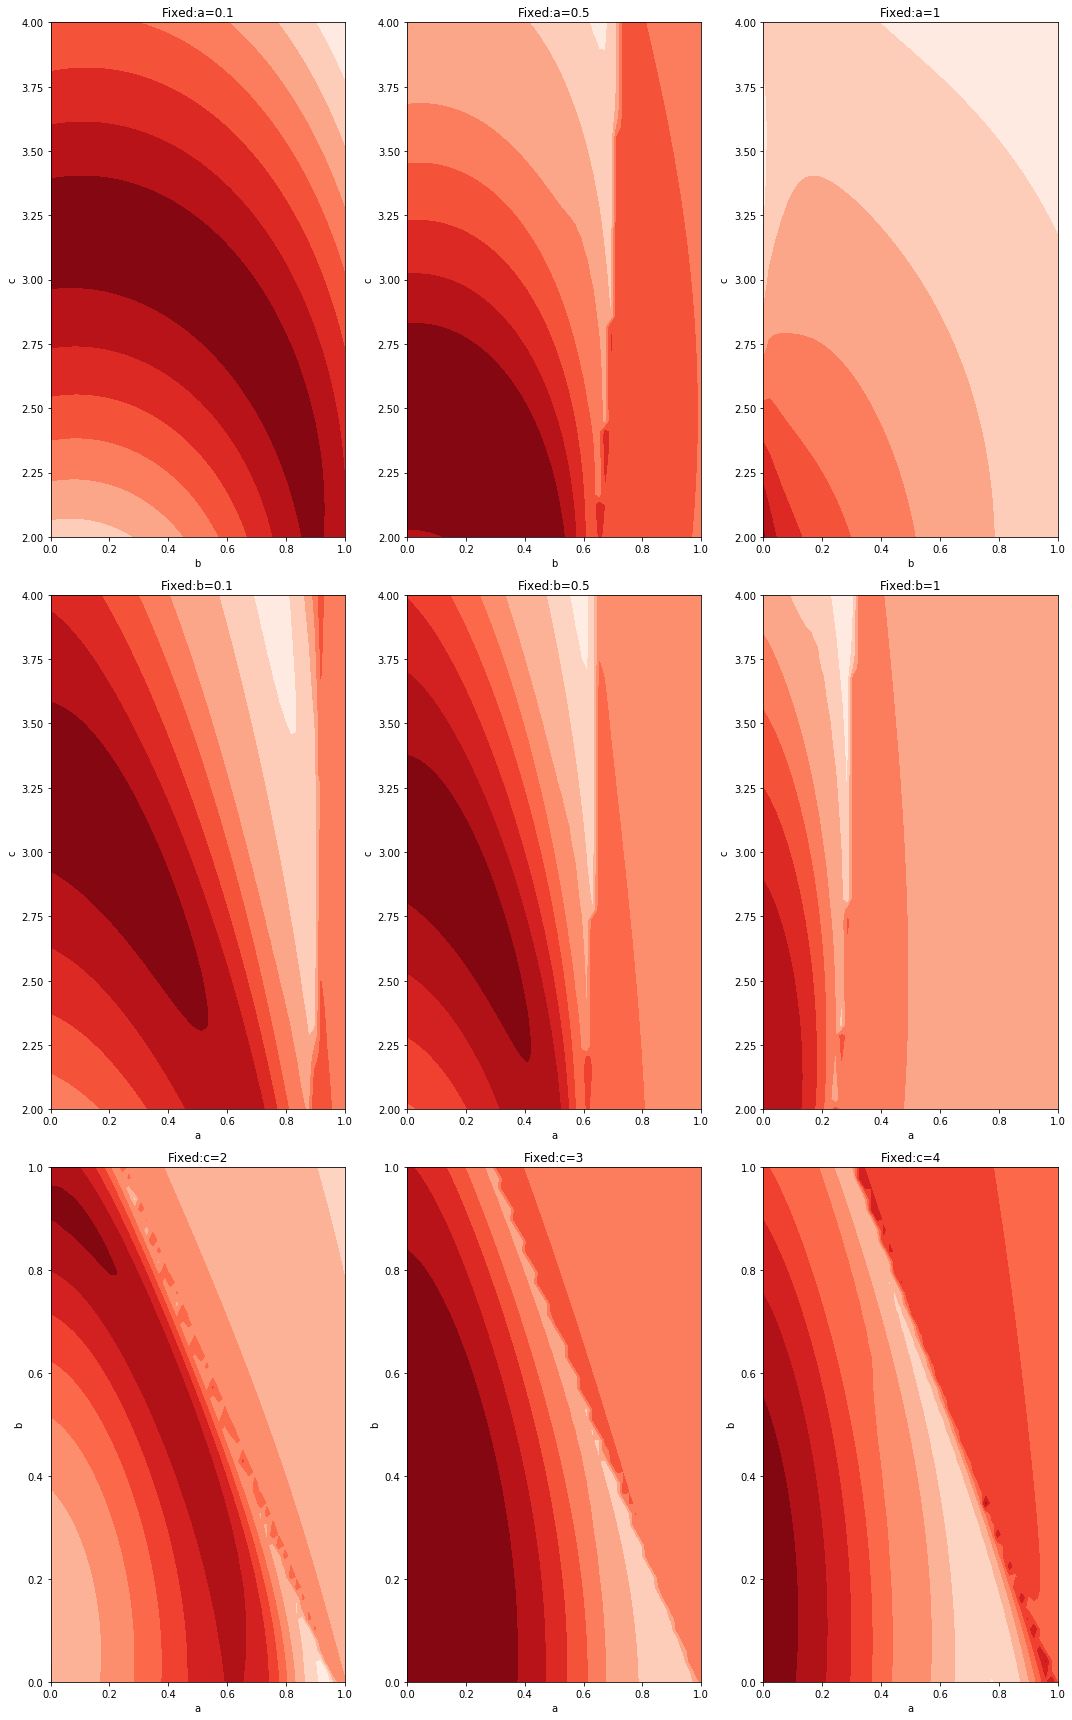

In [8]:
fig, axes = emuplt.plot_fixed_param_grid( 
    real_log_likelihood, 
    fixed_parameters, 
    bounds,
    index_to_param_name=index_to_param_name,
    shape = (3, 3),
    countour = True
)

plt.show(fig)

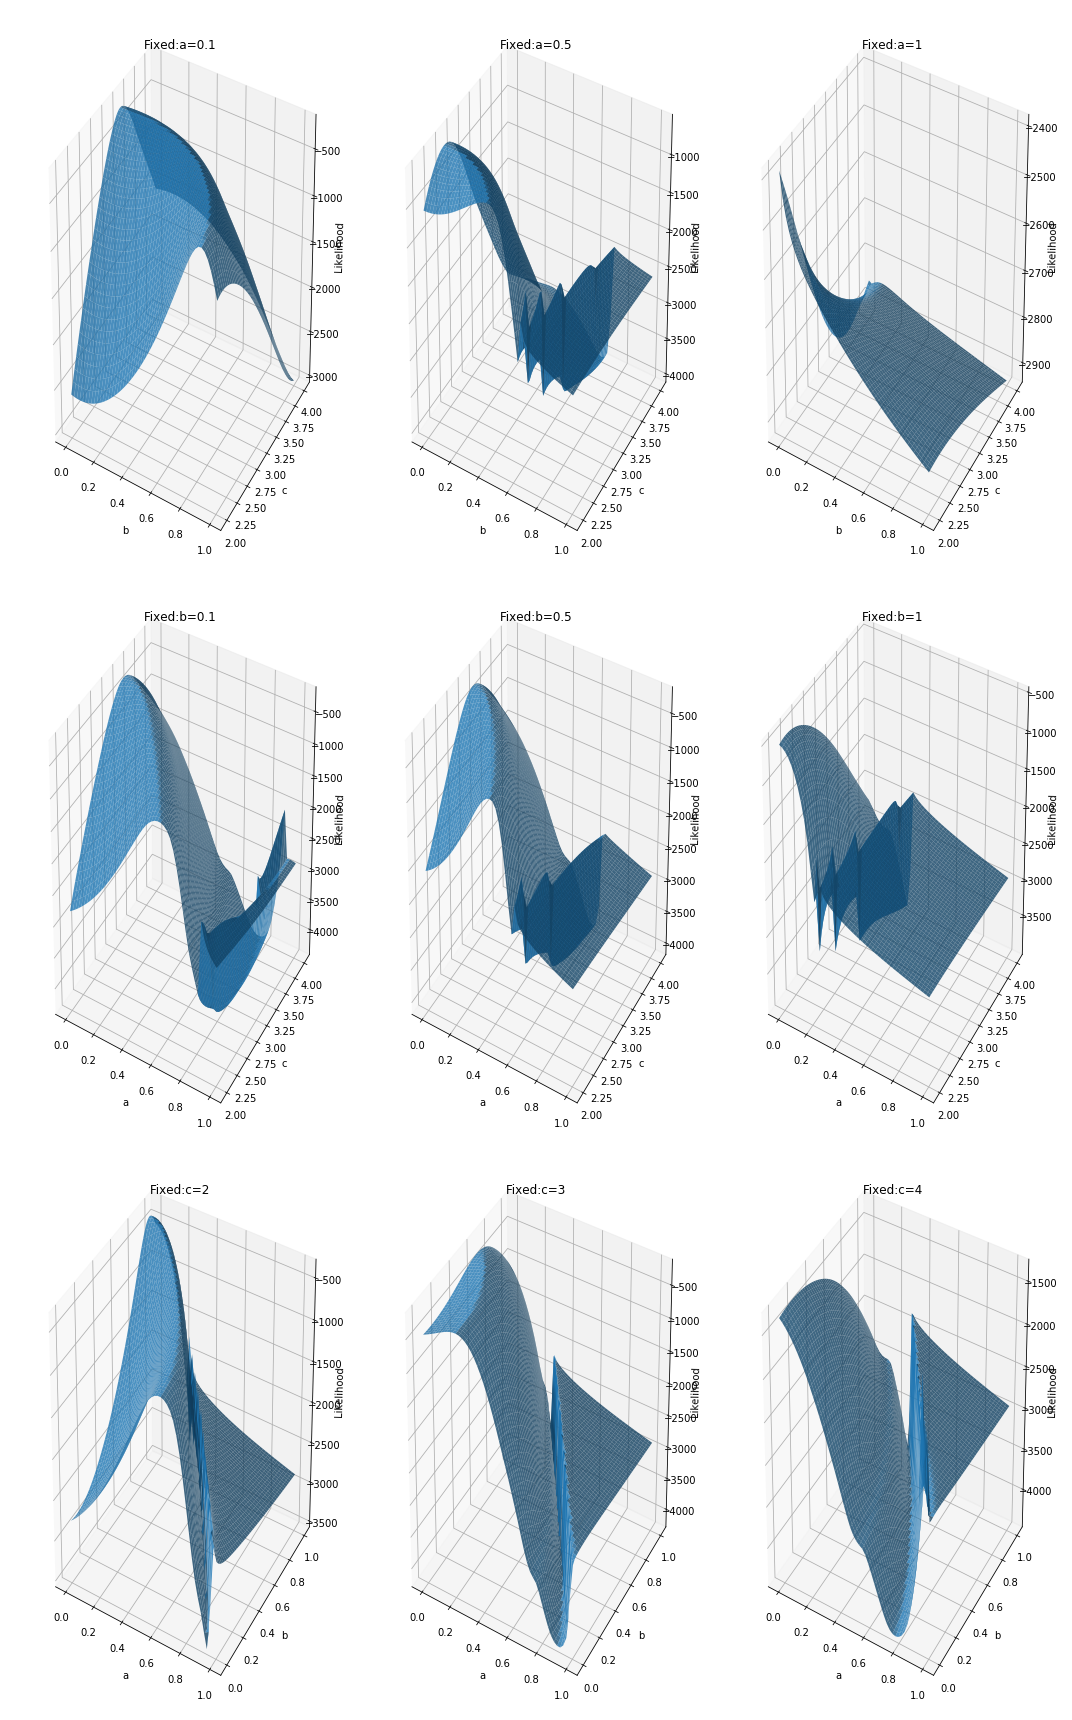

In [9]:
fig, axes = emuplt.plot_fixed_param_grid(real_log_likelihood, 
                                         fixed_parameters,
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         shape = (3, 3),
                                         countour = False
                              )
plt.show(fig)

# Kernel selection

In [10]:
n_parameters = emu.n_parameters()
kernels = [
    GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters),
    GPy.kern.MLP(n_parameters),
    GPy.kern.Matern52(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters),
    GPy.kern.Matern52(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) + GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RatQuad(n_parameters) + GPy.kern.RatQuad(n_parameters),
    GPy.kern.RBF(n_parameters, lengthscale=2) * (GPy.kern.PeriodicMatern52(1) + GPy.kern.MLP(n_parameters)),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) + 
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters),
]

kern_names = [
    "RBF",
    "RatQuad",
    "MLP",
    "Matern52",
    "RatQuad + RBF*RBF",
    "Matern52 + RBF*RBF",
    "RatQuad + RBF + RBF",
    "RatQuad + RatQuad + RatQuad",
    "PeriodicExp + RatQuad + RBF*RBF",
    "RBF + PeriodicMatern52 + MLP",
    "RatQuad + RBF + RatQuad + RBF"
    # Gibbs kernel
]

#optimizer = "scg"
#emu.set_parameters(optimizer = optimizer)

In [11]:
marginal_likelihoods = []

for kern, name in zip(kernels, kern_names):
    # TODO: Test with white noise
    kern += GPy.kern.White(n_parameters)
    emu.set_parameters(kernel = kern)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = 500, messages = False)
    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(name, ml))

RBF: 250.30
RatQuad: 407.92
MLP: 562.82
Matern52: 372.46
RatQuad + RBF*RBF: 433.25
Matern52 + RBF*RBF: 429.04
RatQuad + RBF + RBF: 433.25
RatQuad + RatQuad + RatQuad: 407.92
PeriodicExp + RatQuad + RBF*RBF: 394.14
RBF + PeriodicMatern52 + MLP: 433.25


In [12]:
best_kern = kernels[np.argmax(marginal_likelihoods)]
print(best_kern)

  mlp.             |  value  |  constraints  |  priors
  variance         |    1.0  |      +ve      |        
  weight_variance  |    1.0  |      +ve      |        
  bias_variance    |    1.0  |      +ve      |        


In [13]:
# choose kern that in addition to good marginal log likelihood has small variances in parameters
emu.set_parameters(kernel = kernels[5])
emu.fit(normalizer = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s11  0005  -2.554574e+02   3.403015e+04 
    09s62  0007  -3.358250e+02   3.368529e+03 
    14s51  0011  -3.483860e+02   1.938868e+03 
    33s83  0025  -4.174351e+02   1.691152e+03 
    48s33  0034  -4.289136e+02   4.524274e+01 
    53s09  0037  -4.290379e+02   1.234238e-01 
    56s87  0040  -4.290383e+02   5.179644e-03 
    59s31  0042  -4.290383e+02   1.569372e-04 
Runtime:     59s31
Optimization status: Converged



In [14]:
emu.get_gp()

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


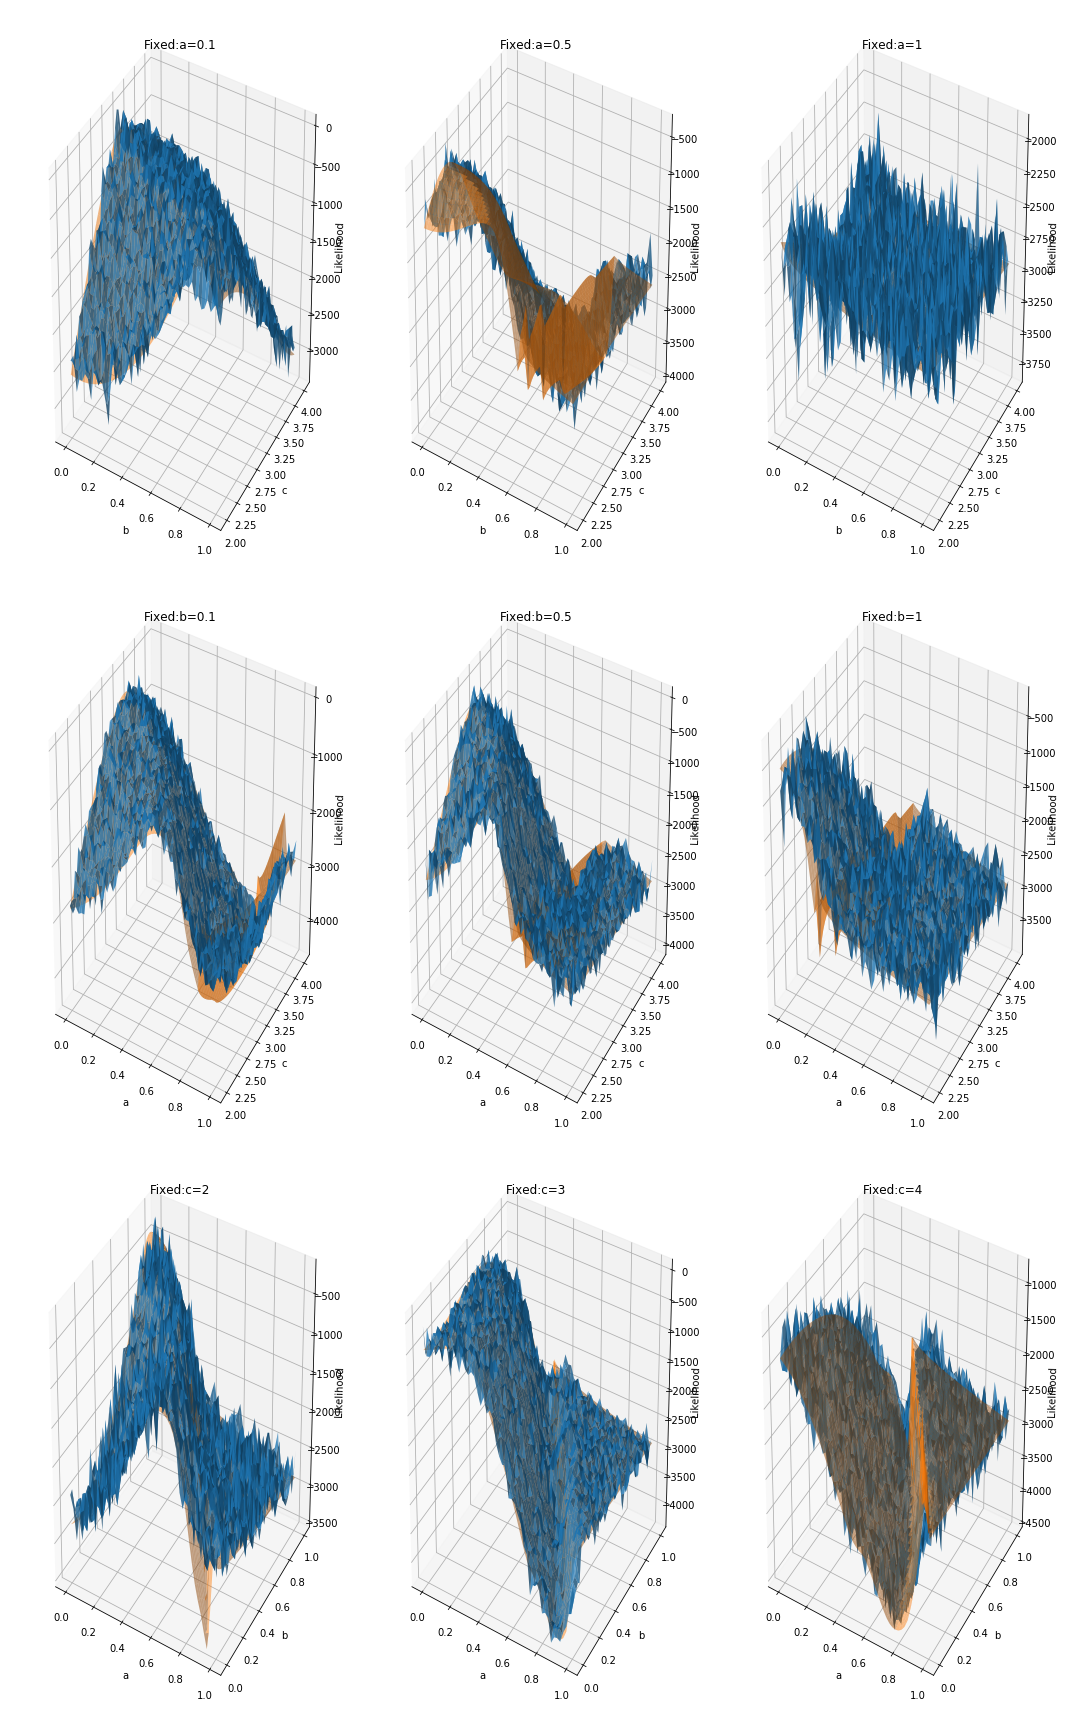

In [15]:
fig, axes = emuplt.plot_fixed_param_grid(emu, 
                                         fixed_parameters, 
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         countour = False,
                                         shape = (3, 3),
                                         additional_log_likelihoods = [real_log_likelihood]
)

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


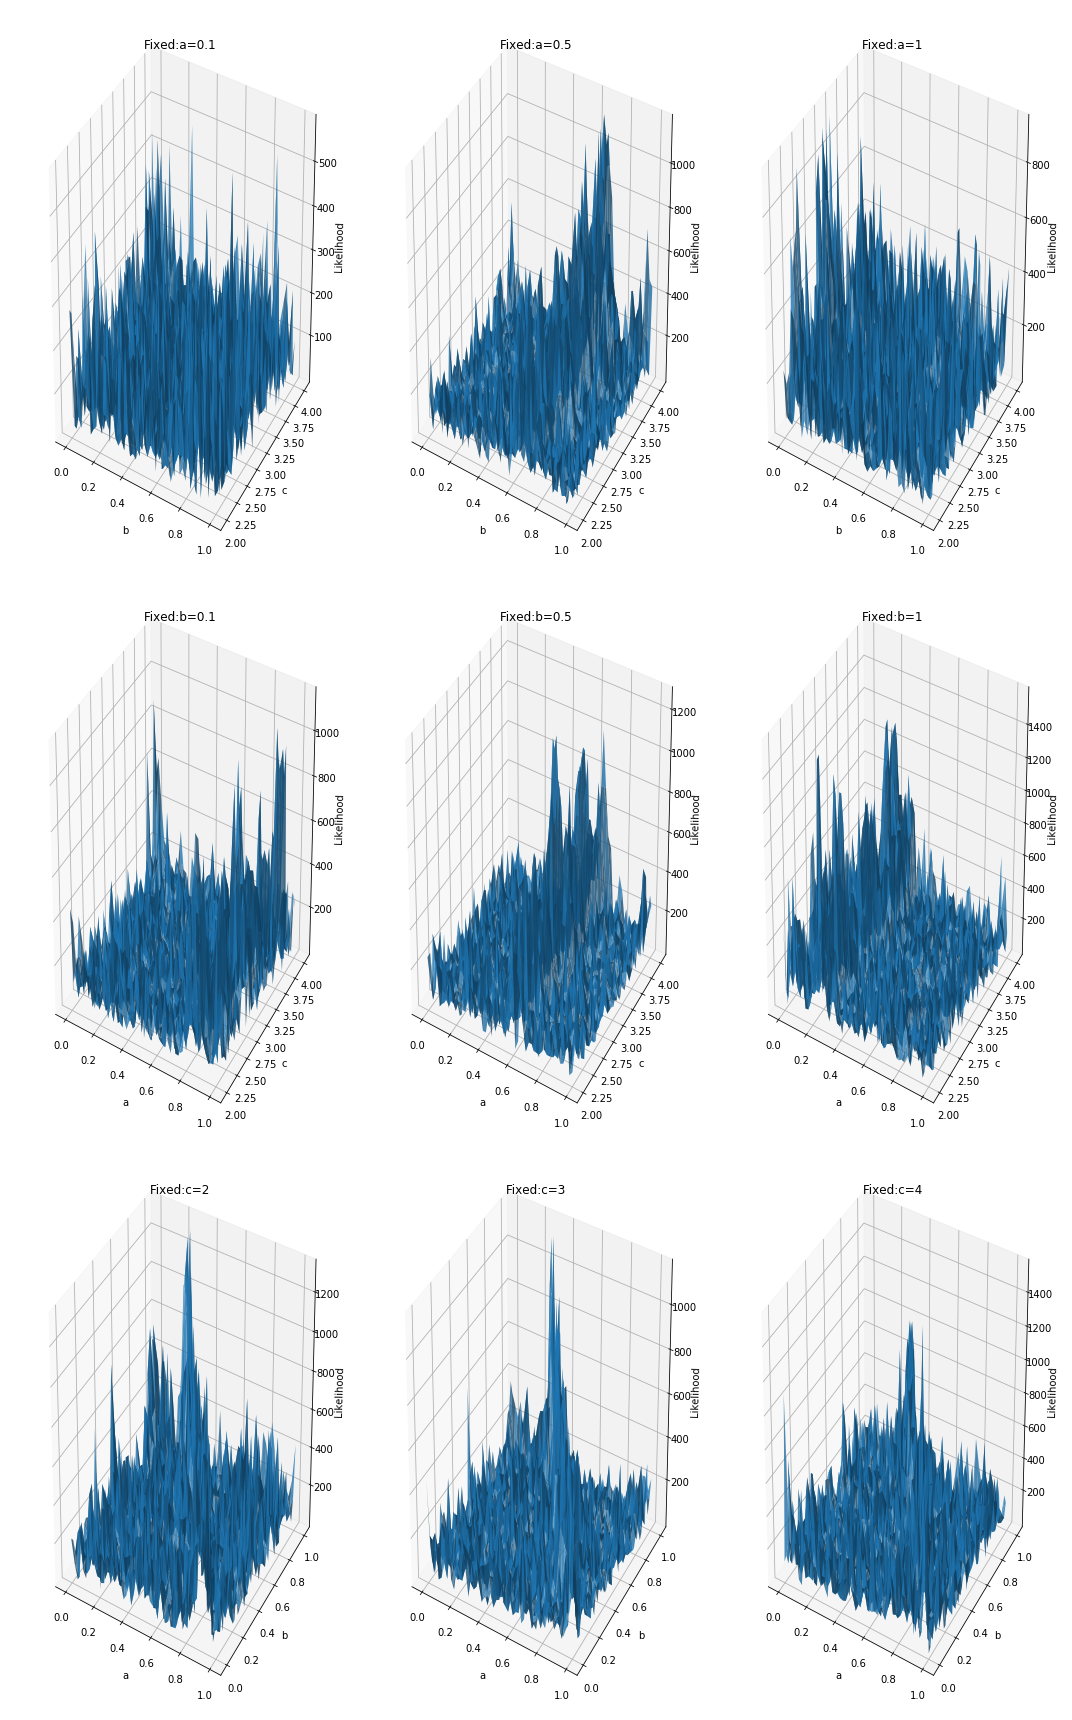

In [16]:
difference_likelihood = lambda x: np.abs(emu(x) - real_log_likelihood(x))
fig, axes = emuplt.plot_fixed_param_grid(difference_likelihood, 
                                         fixed_parameters, 
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         shape = (3, 3),
                                         countour = False,
                                 )

## Timing single prediction

In [17]:
# Model : Time to execute vs number of times (expect to be close to linear?)
# Emulator : Time to execute vs number of training points 
import time

In [18]:
def find_eval_time(func, prior, iters = 10000):
    t_start = time.time()
    for _ in range(iters):
        func(prior.sample(1)[0])
    t_end = time.time()
    return (t_end - t_start) / iters

In [19]:
# Run a simulation
time_splits = [100] + [1000 * i for i in range(1, 21)]
parameters = [0.1, 0.5, 3]
exec_times = []

for time_split in time_splits:
    # Create a log-likelihood function but with more times given
    times = np.linspace(0, 20, time_split)
    org_values = model.simulate(parameters, times)
    values = org_values + np.random.normal(0, noise, org_values.shape)
    problem = pints.MultiOutputProblem(model, times, values)
    log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)
    
    exec_t = find_eval_time(log_likelihood, log_prior, iters = 5000)
    exec_times.append(exec_t)
    print("Time split {}: {}".format(time_split, exec_t))

Time split 100: 0.0030665647983551024
Time split 1000: 0.0029279746055603027
Time split 2000: 0.003122504425048828
Time split 3000: 0.003131531572341919
Time split 4000: 0.003360226821899414
Time split 5000: 0.0032590747833251953
Time split 6000: 0.0033167431831359864
Time split 7000: 0.0034020790100097657
Time split 8000: 0.0033242542266845704
Time split 9000: 0.003476948642730713
Time split 10000: 0.003484642791748047
Time split 11000: 0.0033201089859008787
Time split 12000: 0.03726297578811646
Time split 13000: 0.008038998031616212
Time split 14000: 0.0034379735946655273
Time split 15000: 0.010081558561325074
Time split 16000: 0.006658128356933594
Time split 17000: 0.005290178966522217
Time split 18000: 0.003665078020095825
Time split 19000: 0.010211453580856324
Time split 20000: 0.003841044998168945


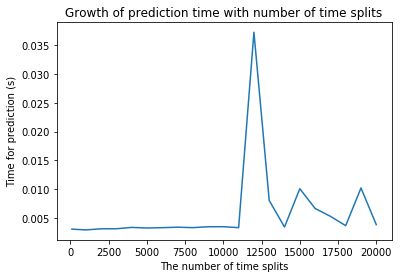

In [20]:
plt.plot(time_splits, exec_times)
plt.title("Growth of prediction time with number of time splits")
plt.xlabel("The number of time splits")
plt.ylabel("Time for prediction (s)")
plt.show()

In [21]:
emu_train_times = []
emu_prediction_times = []

train_sizes = [100 * i for i in range(1, 21)]
print("Kernel used:\n", kern)

for size in train_sizes:
    test_inputs = log_prior.sample(size)
    test_outputs = np.apply_along_axis(real_log_likelihood, 1, test_inputs)
    test_emu = emupints.GPEmulator(real_log_likelihood, test_inputs, test_outputs, normalize_input = True)
    test_emu.set_parameters(kernel = kern)
    
    t_start = time.time()
    test_emu.fit(normalizer = True, messages = False)
    t_end = time.time()
    emu_train_times.append(t_end - t_start)
    
    t_start = time.time()
    find_eval_time(test_emu, log_prior, iters = 10)
    t_end = time.time()
    emu_prediction_times.append(t_end - t_start)
    
    print("Size {}: {:.5f}, {:.5f}".format(size, emu_train_times[-1], emu_prediction_times[-1]))

Kernel used:
   sum.                   |                 value  |  constraints  |  priors
  RatQuad.variance       |   0.16710385286744966  |      +ve      |        
  RatQuad.lengthscale    |   0.18159760727796567  |      +ve      |        
  RatQuad.power          |   0.12358438874566657  |      +ve      |        
  rbf.variance           |   0.27186163397142266  |      +ve      |        
  rbf.lengthscale        |    1.0684768943630059  |      +ve      |        
  RatQuad_1.variance     |   0.16710385286744966  |      +ve      |        
  RatQuad_1.lengthscale  |   0.18159760727796567  |      +ve      |        
  RatQuad_1.power        |   0.12358438874566657  |      +ve      |        
  rbf_1.variance         |   0.27186163397142266  |      +ve      |        
  rbf_1.lengthscale      |    1.0684768943630059  |      +ve      |        
  white.variance         |  0.005335802941136833  |      +ve      |        
Size 100: 333.62529, 0.01376
Size 200: 6.86159, 0.06414


 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Size 300: 0.69262, 0.01397
Size 400: 0.66070, 0.01344
Size 500: 1.44768, 0.01375
Size 600: 1.81245, 0.01462
Size 700: 3.99788, 0.01486
Size 800: 155.86767, 0.02105
Size 900: -1.63485, 0.02311
Size 1000: 10.71386, 0.02125
Size 1100: 23.87839, 0.02245
Size 1200: 27.51756, 0.02619
Size 1300: 20.65570, 0.02594
Size 1400: 17.58042, 0.02413
Size 1500: 54.27052, 0.04410
Size 1600: 35.08851, 0.04867
Size 1700: 74.87054, 0.03638
Size 1800: 73.91654, 0.03981
Size 1900: 87.49256, 0.04063
Size 2000: 82.91170, 0.04370


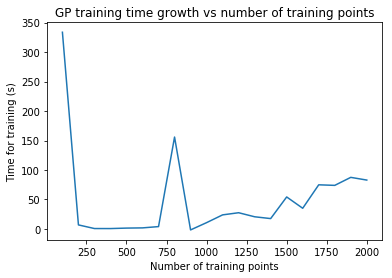

In [22]:
plt.plot(train_sizes, emu_train_times)
plt.title("GP training time growth vs number of training points")
plt.xlabel("Number of training points")
plt.ylabel("Time for training (s)")
plt.show()

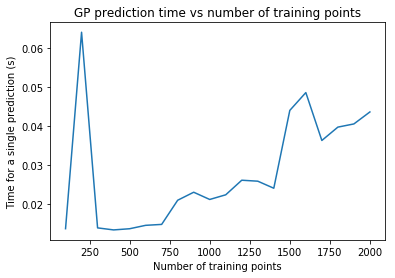

In [23]:
plt.plot(train_sizes, emu_prediction_times)
plt.title("GP prediction time vs number of training points")
plt.xlabel("Number of training points")
plt.ylabel("Time for a single prediction (s)")
plt.show()

## Emulator vs Model

In [24]:
#kern = GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters)
#kern += GPy.kern.White(n_parameters)
train_input = log_prior.sample(4000)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_input)
emu = emupints.GPEmulator(real_log_likelihood, train_input, train_target, normalize_input = True)

In [25]:
emu.set_parameters(kernel = kernels[5])
emu.fit(messages = False, normalizer = True)
emu.get_gp()

In [26]:
emu_posterior = pints.LogPosterior(emu, log_prior)
model_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [27]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]

In [28]:
xs

[array([0.09, 0.45, 2.7 ]),
 array([0.105, 0.525, 3.15 ]),
 array([0.115, 0.575, 3.45 ])]

In [29]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 3, xs, method = pints.PopulationMCMC)
emu_mcmc.set_max_iterations(20000)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...


 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


Done!
CPU times: user 11min 54s, sys: 4.5 s, total: 11min 59s
Wall time: 12min 3s


In [30]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, 3, xs, method = pints.PopulationMCMC)
model_mcmc.set_max_iterations(20000)
model_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 3min 52s, sys: 257 ms, total: 3min 53s
Wall time: 3min 53s


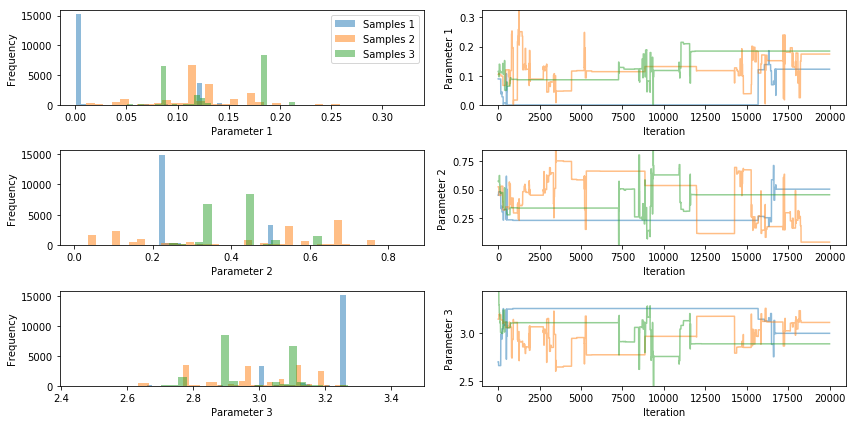

In [31]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

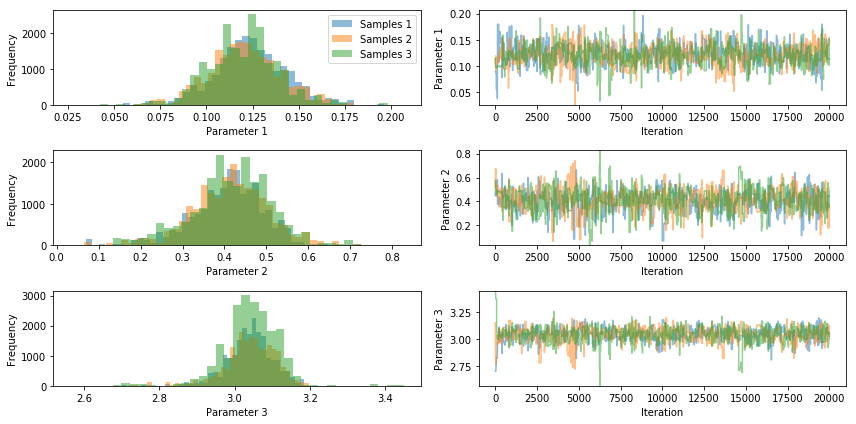

In [32]:
pints.plot.trace(model_chains)
plt.show()

In [33]:
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


In [34]:
model_prediction

array([-609.83506313, -609.83506313, -609.83506313, ..., -198.23481676,
       -198.23481676, -198.23481676])

In [35]:
diffs = np.abs(model_prediction - emu_prediction)

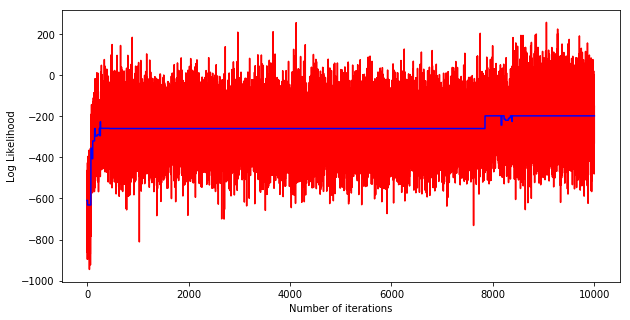

In [36]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color = "Red")
plt.plot(iters, model_prediction, color = "Blue")
plt.show()

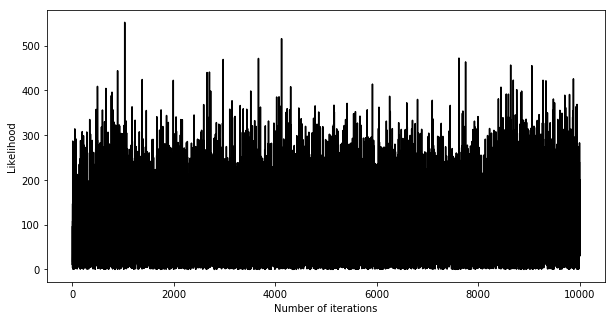

In [37]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

A strong limitation to performance is the size of the training set. If sample uniformly over parameter space the results appear horrible even with high number of training points. Instead, we should sample mostly from high-likelihood areas as they are the ones that are likely to be used by MCMC. 

## post-MCMC emulation

In [38]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, 3, xs, method = pints.PopulationMCMC)
model_mcmc.set_max_iterations(2000)
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

Running...
Using Population MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     3     0     1     no  0     1     no  0     1     no    0:00.0
1     6     6     8     no  4     5     yes 3     8     yes   0:00.0
2     9     7     0     yes 3     9     yes 5     0     no    0:00.0
3     12    3     0     yes 5     3     yes 3     9     yes   0:00.1
20    63    9     4     no  0     7     no  2     0     no    0:00.3
40    123   2     5     no  2     3     no  2     8     no    0:00.5
60    183   7     5     yes 5     3     yes 7     2     yes   0:00.8
80    243   7     2     no  8     4     no  4     7     no    0:01.0
100   303   6     9     no  0     4     no  0     1     no    0:01.3
120   363   6     7     no  2     9     no  5     9     no    0:01.5
140   423   7     3     no  8     0     no  8     5     no    0:01.8
160   483   3     9     no  8     6     yes 5     9     no    0:02.0
180   543   9     0  

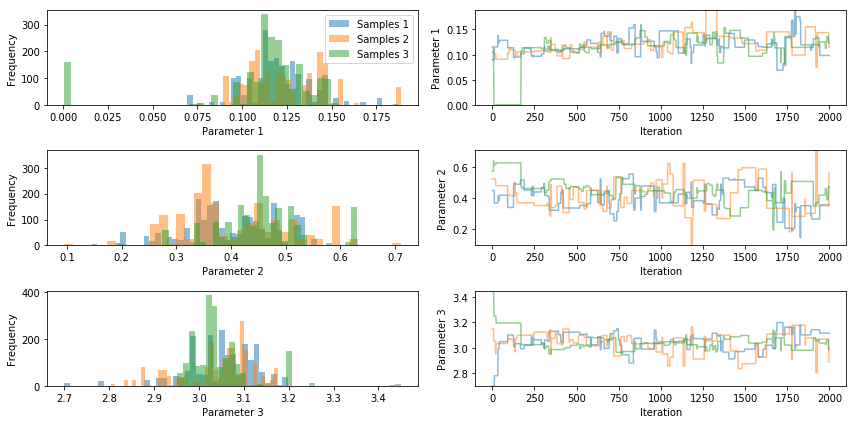

In [39]:
pints.plot.trace(model_chains)
plt.show()

In [40]:
# use small progress in MCMC to derive our train set
train_points = model_chains.reshape((model_chains.size // 3, 3))
train_target = np.apply_along_axis(real_log_likelihood, 1, train_points).flatten()

In [41]:
emu = emupints.GPEmulator(real_log_likelihood, train_points, train_target, normalize_input = True)
emu.set_parameters(kernel = best_kern)
emu.fit(messages = False, normalizer = True)
emu_posterior = pints.LogPosterior(emu, log_prior)

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 3, xs, method = pints.PopulationMCMC)
emu_mcmc.set_max_iterations(10000)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

In [ ]:
pints.plot.trace(emu_chains)
plt.show()

In [ ]:
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color = "Red")
plt.plot(iters, model_prediction, color = "Blue")
plt.show()

In [ ]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

In [ ]:
fig, axes = emuplt.plot_fixed_param_grid(emu, 
                                         fixed_parameters, 
                                         bounds,
                                         index_to_param_name=index_to_param_name,
                                         countour = False,
                                         shape = (3, 3),
                                         additional_log_likelihoods = [real_log_likelihood]
                              )